# Initialization

## Instal package

In [ ]:
# check kaggle version
!pip install kaggle
!pip install dropbox
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 9.9 MB/s eta 0:00:00


## Import package

In [ ]:
import os, sys, time
import zipfile
import warnings
import numpy                 as      np
import pandas                as      pd
import matplotlib.pyplot     as      plt
from   tqdm                  import  tqdm
from   typing                import  List, Tuple
from   skimage               import  io
from   scipy                 import  interpolate
from   dropbox               import  Dropbox
from   scipy.interpolate     import  RegularGridInterpolator
from   scipy.ndimage         import  generic_filter

## Download Dataset

In [ ]:
%%bash
# define download path
data_dir="/content/Kaggle/EMPS"

# delete unrelated
rm -rf "$data_dir"
rm -rf /content/sample_data

# make directory
if [ ! -d "$data_dir" ]; then
  mkdir -p "$data_dir"
fi

# download to directory
kaggle datasets download -d batuhanyil/electron-microscopy-particle-segmentation -p "$data_dir"

# rename
new_name="EMPS.zip"
mv "$data_dir"/electron-microscopy-particle-segmentation.zip "$data_dir"/"$new_name"

# unzip the file
unzip "$data_dir"/"$new_name" -d "$data_dir"

# delete zip file
rm "$data_dir"/"$new_name"

Dataset URL: https://www.kaggle.com/datasets/batuhanyil/electron-microscopy-particle-segmentation
License(s): other

Archive:  /content/Kaggle/EMPS/EMPS.zip
  inflating: /content/Kaggle/EMPS/images/00655d9628.png  
  inflating: /content/Kaggle/EMPS/images/0113230c21.png  
  inflating: /content/Kaggle/EMPS/images/0144266d21.png  
  inflating: /content/Kaggle/EMPS/images/01ac659240.png  
  inflating: /content/Kaggle/EMPS/images/027f25010a.png  
  inflating: /content/Kaggle/EMPS/images/0289bd97e6.png  
  inflating: /content/Kaggle/EMPS/images/032bd4a6b1.png  
  inflating: /content/Kaggle/EMPS/images/0384c4e782.png  
  inflating: /content/Kaggle/EMPS/images/03a1d18cc6.png  
  inflating: /content/Kaggle/EMPS/images/03cd0b2741.png  
  inflating: /content/Kaggle/EMPS/images/04dbda93f9.png  
  inflating: /content/Kaggle/EMPS/images/065d8e352c.png  
  inflating: /content/Kaggle/EMPS/images/06f605c0b1.png  
  inflating: /content/Kaggle/EMPS/images/07330c8ea1.png  
  inflating: /content/Kaggle/EM

100%|██████████| 113M/113M [00:04<00:00, 28.4MB/s]


## Define Classes

In [ ]:
class Graph():
  '''
  A class to represent elemntray Graph

  Usage:
    plot(Graph): plot image
    print(Graph): print image info
    data[x,y]: The image pixel RGB value at (x,y) s a NumPy array

  Attributes:
    data (ndarray): The Graph data loaded as a NumPy array (m x n x 3)
    boundaries (dict): The boundary of the Graph
    vertices (list): The four vertices of the Graph (xmin, ymin, xmax, ymax)
  '''

  def __init__(self, data: np.ndarray, xy_limits=None):
    '''
    input:
      xy_limits (list): The x y limits of the Graph (x_min, x_max, y_min, y_max)
      data (ndarray): The Graph data loaded as a NumPy array
      vertices (list): The four vertices of the Graph (xmin, ymin, xmax, ymax)

    return:
      instance of a Graph
    '''
    # data info
    self.data           = data
    self.dtype          = self.data.dtype
    self.shape          = self.data.shape
    self.size           = self.data.size
    self.xy_limits      = xy_limits
    self.vertices       = self.get_vertices()
    self.boundaries     = self.get_boundaries()

  def __str__(self) -> str:
    graph_info = f'{type(self).__name__} info:\n' \
                 f'size           = {self.size}\n' \
                 f'shape          = {self.data.shape}\n' \
                 f'data type      = {self.data.dtype}\n' \
                 f'variable type  = {type(image_0.data)}\n'\
                 f'\n'
    return graph_info

  def get_vertices(self) -> list[tuple]:
      """
      Calculate vertices from xylimits.

      Returns:
          list: List of vertices as list [(x1, y1), (x2, y2), (x3, y3), (x4, y4)].
      """
      if self.xy_limits is None:
          # Default boundary (using image shape)
          x_min, y_min  = 0, 0
          x_max, y_max  = int(self.shape[0]), int(self.shape[1])
      else:
          # User-provided boundary
          x_min = int(self.xy_limits[0])
          x_max = int(self.xy_limits[1])
          y_min = int(self.xy_limits[2])
          y_max = int(self.xy_limits[3])

      # Calculate vertices (Clockwise in matrix, counter-clockwise in Graph)
      vertices = [(x_min, y_min),
                  (x_max, y_min),
                  (x_max, y_max),
                  (x_min, y_max)]
      # update x y limit
      self.xy_limits = (x_min, x_max, y_min, y_max)
      return vertices

  def get_boundaries(self) -> dict:
      """
      Get the boundary of the image.
      """
      boundaries = {}
      boundaries['x_min'] = int(self.vertices[0][0])
      boundaries['x_max'] = int(self.vertices[1][0])
      boundaries['y_min'] = int(self.vertices[0][1])
      boundaries['y_max'] = int(self.vertices[2][1])
      boundaries['x_len'] = abs(int(boundaries['x_max'] - boundaries['x_min']))
      boundaries['y_len'] = abs(int(boundaries['y_max'] - boundaries['y_min']))
      boundaries['diagonal'] = np.sqrt(boundaries['x_len']**2 + boundaries['y_len']**2)
      return boundaries

  def show(self) -> None:
      '''
      plot the image
      '''
      plt.imshow(self.data)
      plt.show()


class Patch(Graph):
  '''
  A class to represent Patch

  Input:
    xy_limits ([x_min, x_max, y_min, y_max]): The x y limits of the Patch
    x_min/ x_max: row of the Patch pixel matrix
    y_min/ y_max: column of the Patch pixel matrix
    color_mode (str): the coloring mode of the patch, 'black' or 'BinaryInterpolation'

  Attributes:
    host_graph (Graph): The Graph instance that patching to

  Usage:
    plot(Patch): plot image
    print(Patch): print image info

  Note:
    Initial Patch will be black,
    Patch will be colored after add_patch(Patch)
  '''

  def __init__(self, xy_limits: list, color_mode: str):

    # Basic info
    self.xy_limits  = xy_limits
    self.vertices   = self.get_vertices()
    self.boundaries = self.get_boundaries()

    # Iinitialization （as black patch）
    self.color_mode = 'black'
    self.data       = self.get_colored()
    super().__init__(data=self.data, xy_limits=xy_limits)

    # Coloring settings (for add_Patch(Patch))
    self.color_mode = color_mode
    self.host_graph: Graph

  def __str__(self) -> str:
    graph_info = super().__str__()
    patch_info = f'boundary       = {self.boundaries}\n'\
                 f'vertices       = {self.vertices}\n'\
                 f'\n'
    return graph_info + patch_info

  def get_colored(self) -> np.ndarray:

    # set ndarry shape for Graph
    x_len, y_len    = self.boundaries['x_len'], self.boundaries['y_len']
    RGB_shape       = (x_len, y_len, 3)
    GrayScale_shape = (x_len, y_len)


    if self.color_mode == 'Transparent':
      # colored with original inpyt host image
      data = self.host_graph.data.copy()
      data = self.get_taylored(data) # tayloring the size

    elif self.color_mode == 'black':
      # colored with pure plack
      data = np.zeros(RGB_shape)


    elif self.color_mode == 'BinaryInterpolation_4Points':
      # colored with Binary interpolation
      data = bilinear_interpolation_4Points(img=self.host_graph.data, xy_limits=self.xy_limits)
      data = self.get_taylored(data) # tayloring the size

    elif self.color_mode == 'BinaryInterpolation_4Bonds':
      # colored with Bilinear interpolation
      data = bilinear_interpolation_4Bonds(img=self.host_graph.data, xy_limits=self.xy_limits)
      data = self.get_taylored(data) # tayloring the size


    elif self.color_mode == 'BinaryInterpolation_Sliding':
      # colored with Bilinear interpolation
      data = bilinear_interpolation_Sliding(img=self.host_graph.data, xy_limits=self.xy_limits)
      data = self.get_taylored(data) # tayloring the size


    elif self.color_mode == 'GrayScale_background': # for mask only
      # colored for Mask only
      marker = 0  # colored as background
      data = np.full(GrayScale_shape, marker)


    elif self.color_mode == 'GrayScale_out': # for mask only
      # colored for Mask only
      marker = np.max(self.host_graph.data) + self.host_graph.patch_num + 1
      # print(marker)
      data = np.full(GrayScale_shape, marker)


    else:
      error_message = f'Color mode:\n'\
                      f'black, Transparent\n'\
                      f'BinaryInterpolation_(4oints,4Bonds,Sliding)\n'\
                      f'GrayScale_(background,out)'
      raise ValueError(error_message)


    # update
    self.data = data

    return data

  def get_taylored(self, data):
    # tayloring the patch to desired size
    data = data[self.boundaries['x_min']:self.boundaries['x_max'],
                self.boundaries['y_min']:self.boundaries['y_max']]
    return data

  def show(self) -> None:
      '''
      plot the Patch itself
      '''
      plt.imshow(self.data)
      plt.show()


class Image(Graph):
  '''
  A class to represent image

  Usage:
    add_patch(Patch): add single patch to the host Image
    get_data_with_patch(): get the data with patches

  Attributes:
    path (str): path to the image
    name (str): name of the image
    patch_list (list): list of patches of the host Image
    patch_num (int): number of patches of the host Image
  '''

  def __init__(self, path: str):
    '''
    Parameters:
      path (str): path to the image

    return:
      instance of Image
    '''

    # Basic info
    self.path       = path
    self.name       = path.split("/")[-1]
    self.data       = io.imread(self.path)

    # Initialization
    super().__init__(data=self.data)

    # Recording patches
    self.patch_list      = []  # list of patches of the host Image
    self.patch_num       = 0   # number of patches of the host Image
    self.data_with_patch = self.data.copy() # Images with patches

  def attach_patch(self, patch: Patch):
    '''
      Add single patch to the host Image
    '''
    # Assgin the host image to the patch
    patch.host_graph = self

    # Color the attached patch
    patch.get_colored()

    # Attach the patch to the host image
    self.patch_list.append(patch)
    self.patch_num = len(self.patch_list)

    # Update the host image after attachment
    self.get_data_with_patch()

  def get_data_with_patch(self):
    '''
      Get the Image data with patches
    '''

    for patch_i in self.patch_list:
        # Get patch boundaries
        x_min = patch_i.boundaries['x_min']
        x_max = patch_i.boundaries['x_max']
        y_min = patch_i.boundaries['y_min']
        y_max = patch_i.boundaries['y_max']

        # Overlay patch data onto the main image data
        self.data_with_patch[x_min:x_max, y_min:y_max] = patch_i.data

  def show(self, show_pathces=False) -> None:
      '''
      plot the image

      Parameters:
      show_pathces (bool): whether to show patches or not
      '''
      if show_pathces:
        self.get_data_with_patch()
        plt.imshow(self.data_with_patch)
      else:
        plt.imshow(self.data)
      plt.show()

  def __str__(self) -> str:
    graph_info = super().__str__()
    image_info = f'path           = {self.path}\n' \
                 f'name           = {self.name}\n'\
                 f'boundary       = {self.boundaries}\n'\
                 f'vertices       = {self.vertices}\n'\
                 f'patch_list     = {self.patch_list}\n'\
                 f'patch_num      = {self.patch_num}\n'\
                 f'\n'
    return graph_info + image_info


class Mask(Image):
  '''
  A class to represent mask

  Usage:
    plot(Mask): plot image
    print(Mask): print image info
    data[x,y]: The image    value at (x,y) s a NumPy
  '''
  def __init__(self, path: str):
    '''
    Parameters:
      path (str): path to the mask

    return:
      instance of Mask
    '''
    super().__init__(path)
    pass

  def __str__(self) -> str:
    return super().__str__()

## Deine Functions


In [ ]:
def add_average_border(image: np.ndarray) -> np.ndarray:
  """Calculates the average RGB values and applies them to the image border.

  Args:
    image: The input RGB image as an ndarray.

  Returns:
    The image with the average RGB border.
  """

  # Calculate the average RGB values
  average_color = np.mean(image, axis=(0, 1), dtype=int)

  # Apply the average color to the image border
  image[0,  :, :] = average_color  # Top border
  image[-1, :, :] = average_color  # Bottom border
  image[:,  0, :] = average_color  # Left border
  image[:, -1, :] = average_color  # Right border

  return image


In [ ]:
def bilinear_interpolation_4Points(img: np.ndarray, xy_limits: list):
    """
    Perform bilinear interpolation on an RGB image.
    This function processes the entire input image without changing its dimensions.

    Parameters:
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """
    # Fetch info
    x_min, x_max, y_min, y_max = xy_limits
    width, height = x_max - x_min + 1, y_max - y_min + 1
    _, _, channels = img.shape
    interpolated_img = np.zeros_like(img) # host image


    # Loop over R, G, B channels
    for c in range(channels):

        # Fetch pixel values from the 4 fixed points
        Q11 = img[x_min, y_min, c]  # Top-left
        Q12 = img[x_max, y_min, c]  # Top-right
        Q21 = img[x_min, y_max, c]  # Bottom-left
        Q22 = img[x_max, y_max, c]  # Bottom-right

        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):

                # Compute interpolation weights
                weight_x = (x - x_min) / width
                weight_y = (y - y_min) / height

                # Bilinear interpolation formula
                T = Q11 * (1-weight_x) + weight_x * Q12
                B = Q21 * (1-weight_x) + weight_x * Q22
                P = B * weight_y + T * (1-weight_y)

                interpolated_img[x, y, c] = P


    return interpolated_img


# major method
def bilinear_interpolation_4Bonds(img: np.ndarray, xy_limits: list):
    """
    Perform bilinear interpolation on an RGB image.
    This function processes the entire input image without changing its dimensions.

    Note:
        This method uses 4 sliding boundaries rather than 4 fixed corner points.
        The 4 points are projections of the current point to the top, bottom, left, and right edges.

    Parameters:
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """
    # Initiation
    img = img.copy()
    x_min, x_max, y_min, y_max = xy_limits
    height, width = x_max - x_min + 1, y_max - y_min + 1
    _, _, channels = img.shape
    interpolated_img = np.zeros_like(img)

    # add border (for dealing with rigid huge label)
    img = add_average_border(img)

     # Loop over R, G, B channels
    for c in range(channels):
        for x in range(x_min, x_max+1):
            for y in range(y_min, y_max+1):

                # Compute interpolation weights
                weight_x = (x-x_min) / height
                weight_y = (y-y_min) / width

                # Fetch pixel values from sliding projection points
                Q_Top   = img[x_min,  y,      c]  # Top boundary
                Q_Bot   = img[x_max,  y,      c]  # Bottom boundary
                Q_Left  = img[x,      y_min,  c]  # Left boundary
                Q_Right = img[x,      y_max,  c]  # Right boundary

                # Bilinear interpolation formula using boundary projections
                H = Q_Top * (1 - weight_x) + Q_Bot  * weight_x
                V = Q_Left  * (1 - weight_y) + Q_Right * weight_y

                interpolated_img[x, y, c] = (H+V)/2

    return interpolated_img


def bilinear_interpolation_Sliding(img: np.ndarray, xy_limits: list, WindowScale=0.8) -> np.ndarray:
    """
    Perform bilinear interpolation on an RGB image.
    This function processes the entire input image without changing its dimensions.

    Parameters:
        xy_llimits (list): [x_min, x_max, y_min, y_max]
        WindowScale (int): the scale of the sliding window, higher means extract nearer neighboring pixels
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """

    # Fetch info
    x_min, x_max, y_min, y_max = xy_limits
    height, width  = x_max - x_min + 1, y_max - y_min + 1
    full_height, full_width, channels = img.shape
    interpolated_img = np.zeros_like(img) # host image

    # Determing sliding window geometry
    window_width  = width  // WindowScale
    window_height = height // WindowScale

    # Loop over R, G, B channels
    for c in range(channels):
        for x in range(x_min, x_max):
            for y in range(y_min, y_max):

                # Make sliding window geometry adaptive
                window_x_min = max(int(x - 0.5 * window_height), 0)
                window_x_max = min(int(x + 0.5 * window_height), full_height-1)
                window_y_min = max(int(y - 0.5 * window_width),  0)
                window_y_max = min(int(y + 0.5 * window_width),  full_width-1)

                # Fetch pixel values from the 4 fixed points
                Q11 = img[window_x_min, window_y_min, c]  # Top-left
                Q12 = img[window_x_min, window_y_max, c]  # Top-right
                Q21 = img[window_x_max, window_y_min, c]  # Bottom-left
                Q22 = img[window_x_max, window_y_max, c]  # Bottom-right


                # Compute interpolation weights
                weight_x = (x - window_x_min) / (window_x_max - window_x_min + 1e-5)  # Add 1e-5 to denominator
                weight_y = (y - window_y_min) / (window_y_max - window_y_min + 1e-5)  # Add 1e-5 to denominator

                # Bilinear interpolation formula
                T = Q11 * (1-weight_x) + weight_x * Q12
                B = Q21 * (1-weight_x) + weight_x * Q22
                P = B * weight_y + T * (1-weight_y)

                interpolated_img[x, y, c] = P


    return interpolated_img


def bilinear_interpolation_Sliding_Dynamic(img: np.ndarray, xy_limits: list, min_window=5, max_window=20) -> np.ndarray:
    """
    Perform bilinear interpolation on an RGB image with adaptive window scaling based on local variance.
    This function processes the entire input image without changing its dimensions.

    Parameters:
        xy_limits (list): [x_min, x_max, y_min, y_max]
        min_window (int): Minimum sliding window size.
        max_window (int): Maximum sliding window size.
        img (numpy.ndarray): Input image of shape (height, width, 3).

    Returns:
        numpy.ndarray: Image after bilinear interpolation with the same shape.
    """

    # Fetch info
    x_min, x_max, y_min, y_max = xy_limits
    full_height, full_width, channels = img.shape
    interpolated_img = np.zeros_like(img)  # Output image

    # Function to calculate local variance
    def local_variance(window):
        return np.var(window)

    # Calculate variance map for grayscale image
    grayscale = img.mean(axis=2)  # Convert to grayscale
    variance_map = generic_filter(grayscale, local_variance, size=5)

    # Normalize variance map to dynamic window scale
    WindowScale_map = np.clip((variance_map - variance_map.min()) / (variance_map.max() - variance_map.min()) * max_window,
                              min_window, max_window)

    # Loop over R, G, B channels
    for c in range(channels):
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):

                # Dynamically determine the window scale for each pixel
                WindowScale = WindowScale_map[x, y]
                window_width  = int(WindowScale)
                window_height = int(WindowScale)

                # Make sliding window geometry adaptive
                window_x_min = max(int(x - 0.5 * window_height), 0)
                window_y_min = max(int(y - 0.5 * window_width),  0)
                window_x_max = min(int(x + 0.5 * window_height), full_height-1)
                window_y_max = min(int(y + 0.5 * window_width),  full_width-1)

                # Fetch pixel values from the 4 fixed points
                Q11 = img[window_x_min, window_y_min, c]  # Top-left
                Q21 = img[window_x_max, window_y_min, c]  # Top-right
                Q12 = img[window_x_min, window_y_max, c]  # Bottom-left
                Q22 = img[window_x_max, window_y_max, c]  # Bottom-right

                # Compute interpolation weights
                weight_x = (x - window_x_min) / (window_x_max - window_x_min + 1e-5)
                weight_y = (y - window_y_min) / (window_y_max - window_y_min + 1e-5)

                # Bilinear interpolation formula
                T = Q11 * (1 - weight_y) + Q12 * weight_y
                B = Q21 * (1 - weight_y) + Q22 * weight_y
                P = T * (1 - weight_x) + B * weight_x

                interpolated_img[x, y, c] = P

    return interpolated_img


def zip_folder(folder_path, output_path):
  """
  Compress folder to zip file
  """
  with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))


## Define Patch Coordinates Data Base

In [ ]:
class Patch_Databas:
     def __init__(self):
          # patches_list (dic): {'name': [points_set_1, points_set_2]}
          # points_set_1 (list): [point_uper_left, point_botom_right]
          # point (tuple): (x,y)
          # x,y (float): x,y coordinate in x,y plane (NOT Matrix row column)


          # dic for recording patches vertices
          self.patches_dic = {
               '7a48f5b4d5':[[(0,0),(70,62)],
                              [(0,450),(191,508)]],
               'aa968ec1b2':[[(0,0),(78,92)],
                              [(522,423),(707,499)]],
               '5fc8c5b53c':[],
               'ce41e4e56d':[[(0,0),(53,103)],
                              [(490,397),(737,511)]],
               '9c9d1af243':[[(7,35),(51,86)],
                              [(0,400),(160,505)]],
               '7c5501d292':[[(10,0),(103,130)]],
               '62e729e838':[[(0,0),(69,69)],
                              [(420,440),(511,511)]],
               'a492171fa8':[[(0,0),(49,51)],
                              [(361,461),(511,498)],
                             [(0,508),(511,528)]],
               '296a52bf09':[],
               '1cb46bfdd5':[[(0,0),(145,121)],
                              [(510,353),(749,511)]],
               '99eb4bad25':[[(21,27),(98,89)],
                              [(27,420),(167,490)]],

               '671b7c8831':[[(568,13),(684,52)],
                             [(518,497),(684,511)]],
               'f7f7093f0f':[[(606,28),(670,78)],
                         [(537,432),(659,488)]],
               'a68915823c':[[(0,0),(60,67)],
                         [(420,446),(726,508)]],
               '555eb05b4c':[[(19,47),(58,89)],
                         [(0,476),(682,511)]],
               '923cab32ee':[],
               '6360a823da':[[(18,24),(82,94)],
                         [(18,428),(177,508)]],
               'e853d120fa':[[(0,0),(46,50)],
                         [(385,456),(510,494)],
                         [(0,506),(511,527)]],
               '434e287439':[[(16,443),(170,500)]],
               '3430b20071':[[(0,0),(73,77)],
                         [(12,466),(99,500)]],
               '7b76562318':[[(0,12),(48,70)],
                         [(0,465),(722,511)]],
               'c0ba8a65a5':[[(0,0),(102,101)],
                         [(0,425),(186,511)]],
               '48f3a148f6':[[(0,0),(61,48)],
                         [(359,489),(778,511)]],
               'b85f5e414c':[[(15,22),(42,54)],
                         [(404,441),(551,511)]],
               '391ef00939':[[(16,9),(67,51)],
                         [(418,461),(511,511)]],
               'a8851978de':[[(413,480),(560,511)]],
               'c7e9ec8d48':[[(0,0),(44,58)],
                         [(0,419),(150,511)]],
               '2897b777fe':[[(0,0),(84,84)],
                              [(0,446),(124,511)]],
               '3f97a9e821':[[(402,465),(516,506)]],
               'dfeaa0d54b':[[(0,0),(72,67)],
                         [(23,427),(238,495)]],
               'fc2851e6d3':[[(353,449),(477,502)]],
               '63df66fb4d':[[(0,473),(84,511)],
                         [(547,430),(669,506)]],
               '8136144eaf':[[(460,13),(517,63)],
                         [(332,475),(554,511)]],
               'c294fece54':[[(481,0),(537,58)],
                         [(307,473),(558,508)]],
               '427ebc9e15':[[(57,452),(675,500)]],
               '85f5efb77d':[],
               'f7fa7d1729':[[(0,0),(83,78)],
                         [(3,438),(143,502)]],
               '4628753cd8':[[(0,461),(670,511)]],
               '2556313831':[[(0,0),(109,53)],
                         [(4,451),(120,511)]],
               'c812c93fbd':[[(5,13),(39,62)],
                          [(252,448),(546,511)]],
               'e3a800b533':[[(28,31),(72,79)],
                         [(9,470),(80,507)]],
               'a1315df346':[[(28,444),(245,489)]],
               'bf901d32a3':[[(0,0),(110,96)],
                         [(567,436),(634,493)]],
               '80d6a1f25a':[[(0,0),(67,70)],
                         [(391,445),(504,494)]],
               '707120d0f5':[[(21,435),(331,507)]],
               'c1d32ab54d':[],
               '398ae34c19':[[(0,0),(63,79)],
                         [(536,414),(745,511)]],
               'fcc97c015c':[[(0,0),(62,49)],
                         [(313,431),(434,468)],
                         [(0,476),(634,511)]],
               '2daa27a6df':[],
               'b452204939':[[(0,0),(41,45)],
                         [(0,472),(557,511)]],
               '6169a602a0':[],
               '5898a2ac02':[[(0,482),(62,511)]],
               'aa309f6cec':[[(0,0),(54,48)],
                         [(424,452),(511,511)]],
               'a4b639ab1a':[[(0,0),(64,91)],
                         [(0,451),(128,505)]],
               'a3eb38c236':[[(585,25),(650,75)],
                         [(0,462),(140,508)]],
               'f3b36fb2ab':[],
               '1e011bd992':[],
               '62594342ac':[[(355,446),(893,509)]],
               'a59bcf3f13':[],
               '5eb66b74ea':[[(339,429),(511,511)]],
               'd933f429cc':[[(6,12),(33,63)],
                        [(308,444),(546,511)]],
               '22c776b059':[[(0,0),(91,93)],
                         [(549,422),(717,491)]],
               'ddffc403e3':[[(0,0),(68,68)],
                         [(505,449),(647,511)]],
               '9fac661e24':[],
               '627acee9c4':[[(22,30),(57,66)],
                         [(6,463),(88,504)]],
               '9246d32fe0':[[(683,23),(738,69)],
                         [(8,452),(140,505)]],
               'cf6823322f':[[(0,0),(66,73)],
                         [(476,427),(632,511)]],
               '065d8e352c':[[(363,434),(524,511)]],
               '53025d5189':[[(21,13),(55,48)],
                         [(6,466),(101,510)]],
               'ae843e9fc0':[[(19,67),(73,121)],
                         [(317,413),(617,511)]],
               '8b40ed2a82':[[(558,14),(624,73)],
                         [(4,468),(116,507)]],
               '3a8af6d3f4':[[(468,8),(497,41)],
                         [(12,479),(104,507)]],
               '0e41d62d5d':[[(7,15),(47,47)],
                         [(11,470),(90,508)]],
               '22d5aab090':[[(684,26),(743,71)],
                         [(12,465),(124,506)]],
               'd90c9c5b72':[[(0,0),(100,100)],
                         [(600,417),(721,471)]],
               'e211d9d7ac':[[(0,0),(65,65)],
                         [(346,491),(372,511)],
                         [(463,493),(660,511)]],
               '291898b7c6':[[(0,0),(81,86)],
                         [(366,448),(482,502)]],
               '41ac55ed12':[[(72,25),(153,97)],
                         [(530,415),(661,494)]],
               '6e16b7dcb7':[[(0,0),(65,87)],
                         [(14,427),(170,505)]],
               'ee8a331d06':[[(0,0),(48,35)],
                         [(10,473),(73,503)]],
               '43875c5b20':[[(0,0),(85,77)],
                         [(419,443),(572,504)]],
               '441414704c':[[(15,17),(60,64)],
                         [(370,451),(511,511)]],
               '7701ac03c1':[[(13,46),(66,104)],
                         [(0,392),(174,485)]],
               '00655d9628':[[(0,40),(60,88)],
                         [(419,477),(511,514)]],
               '78834ed976':[[(10,26),(45,67)]],
               '87429394b0':[[(0,0),(74,73)],
                         [(602,426),(747,490)]],
               '173c98ef82':[[(5,466),(99,509)]],
               'af2a275342':[[(0,0),(86,97)],
                         [(6,438),(101,504)]],
               'c355821ea6':[[(25,24),(74,56)]],
               'f664201c62':[[(411,477),(550,511)]],
               'e49e69fd61':[[(15,10),(186,48)],
                         [(426,432),(532,500)]],
               '82b9b9c2af':[[(15,11),(76,68)],
                         [(18,443),(186,503)]],
               '4ec7671d11':[[(0,0),(147,104)],
                             [(0,473),(629,511)]],
               '027f25010a':[[(24,553),(129,600)],
                             [(0,0),(12,112)]],
               '864a2a6ccf':[[(5,14),(48,60)],
                              [(20,400),(200,488)]],
               '2ee0518d7a':[],
               '2181ebb330':[[(0,0),(83,65)],
                              [(0,468),(168,511)]],
               '9797ed1000':[[(0,0),(60,83)],
                              [(482,447),(665,511)]],
               '8b7ce99d43':[[(8,26),(100,100)],
                              [(532,423),(648,471)]],
               '98a18b7db9':[[(15,21),(104,96)],
                             [(583,421),(744,510)]],
               'cecb19b837':[[(0,0),(64,73)],
                              [(251,0),(511,68)],
                              [(341,427),(511,511)]],
               '21308b3614':[[(12,16),(86,82)],
                              [(0,475),(637,511)]],
               '6643f01cf4':[[(25,441),(181,490)]],
               'ec2cc16d2a':[[(0,0),(84,74)],
                         [(420,404),(620,470)]],
               '986f86c3b5':[[(0,0),(61,76)],
                         [(0,420),(174,511)]],
               '3bbd05202e':[[(13,12),(152,48)],
                         [(490,444),(573,489)]],
               '84a6330bdb':[[(42,437),(146,503)]],
               '77f09d7ca4':[[(0,0),(53,63)]],
               '74ef917e76':[[(17,7),(76,60)],
                         [(467,451),(723,504)]],
               '42750053e0':[[(4,14),(50,54)],
                         [(12,428),(130,480)]],
               '9d358e8c8a':[],
               '78847f96ee':[[(7,17),(77,73)],
                         [(327,0),(689,45)],
                         [(11,424),(174,491)]],
               '39dda96b25':[[(0,0),(50,50)],
                         [(366,470),(511,501)],
                         [(0,510),(511,527)]],
               '544b32e4cd':[[(0,0),(37,37)],
                         [(5,483),(72,504)]],
               '47286679c2':[[(0,447),(685,511)]],
               '5e22377208':[],
               '83afcabd95':[[(592,0),(728,153)],
                         [(11,454),(119,506)]],
               'f6c0d8967e':[],
               '39b3a6db5e':[[(0,480),(517,511)]],
               '513158cf83':[[(0,0),(85,67)],
                         [(5,429),(329,487)]],
               '89e4044418':[[(14,437),(148,506)]],
               'e1adc2ba25':[[(11,17),(81,93)],
                         [(535,430),(688,504)]],
               '39b0dc1f52':[[(0,0),(60,63)],
                         [(0,460),(680,511)]],
               '207bb15702':[[(0,0),(64,97)],
                         [(532,427),(742,511)]],
               '34864e691e':[[(437,26),(511,93)],
                         [(350,435),(477,500)]],
               '25af264996':[[(28,424),(202,487)]],
               '7e85b64066':[[(11,13),(87,104)],
                         [(0,457),(631,511)]],
               '80719af02f':[],
               '535134e785':[[(11,12),(81,72)],
                             [(4,445),(115,510)]],
               '0289bd97e6':[[(0,0),(58,64)],
                         [(14,435),(144,485)]],
               '0144266d21':[[(340,468),(500,500)]],
               '4822787326':[],
               'd6613c4ec5':[[(0,0),(98,89)],
                         [(456,414),(615,511)]],
               'b2f6f1bbf9':[[(0,0),(128,107)],
                         [(455,444),(560,511)]],
               '5a25d179cc':[[(0,478),(732,511)]],
               '93ed483d79':[[(26,503),(188,569)]],
               'a880175367':[[(357,436),(487,503)]],
               '5d72761807':[[(0,0),(221,46)]],
               'f7f9125fb0':[[(439,24),(526,90)],
                         [(30,417),(152,487)]],
               '2dadb1ced1':[[(39,70),(93,135)],
                         [(23,448),(165,492)]],
               '76dde347fc':[[(465,9),(495,41)],
                         [(9,474),(105,506)]],
               '5addfe7111':[[(0,0),(64,78)],
                         [(3,464),(81,508)]],
               '06f605c0b1':[[(0,0),(41,40)],
                         [(5,486),(73,509)]],
               '0ca41ed5b8':[[(15,47),(114,110)],
                         [(8,461),(124,493)]],
               '23d581d8a9':[[(0,0),(71,75)],
                         [(411,475),(503,496)]],
               'c1cccb3332':[[(4,19),(46,64)],
                         [(3,463),(101,510)]],
               'bfb2a25730':[[(13,22),(84,83)],
                         [(8,428),(223,499)]],
               'fc9e19325c':[[(6,11),(41,47)],
                         [(11,490),(90,529)]],
               'b2a7683174':[[(489,11),(516,41)],
                         [(211,457),(292,498)]],
               '01ac659240':[[(470,451),(551,493)]],
               'e4065c11e4':[[(9,8),(59,52)],
                         [(428,444),(554,503)]],
               '5c244a9ea8':[[(0,466),(668,511)]],
               'ce6d981687':[[(12,20),(112,105)],
                         [(585,430),(765,511)]],
               'a630b192d4':[[(0,0),(63,69)]],
               '7fabcfe23f':[[(8,14),(51,55)],
                         [(0,477),(633,511)]],
               'd28fb3e471':[[(693,0),(739,44)],
                         [(0,487),(100,511)]],
               'c363833ad2':[[(0,0),(123,103)],
                         [(435,444),(527,489)]],
               '73e0a09cd2':[[(9,14),(39,51)],
                         [(9,465),(90,508)]],
               '245e1a4826':[[(0,472),(519,511)]],
               'fff35f80e1':[[(6,463),(113,507)]],
               '8fde53b05f':[],
               'eb67400438':[[(0,0),(31,34)],
                         [(6,472),(169,511)]],
               '1e0f5d817e':[[(16,15),(101,89)],
                         [(33,425),(183,492)]],
               '78b42bc5e8':[[(16,28),(65,77)],
                         [(515,436),(595,495)]],
               'f9d59dcb02':[],
               '39e18a8f4c':[[(5,25),(82,94)],
                         [(519,438),(617,511)]],
               '2e5dab1969':[[(7,21),(52,73)],
                         [(13,456),(130,505)]],
               '6fe6ed78ab':[[(432,105),(559,218)]],
               '7ea28e7e54':[[(11,16),(108,80)],
                             [(470,488),(764,510)]],
               'd29d644539':[[(0,0),(104,88)],
                         [(0,483),(588,511)]],
               '3537f150cd':[[(8,468),(212,510)]],
               'a8e3f32537':[[(0,0),(117,68)],
                         [(580,435),(676,493)]],
               'f58490bdaf':[],
               'bc5529f7ca':[[(616,0),(680,69)],
                         [(0,477),(681,511)]],
               '7f50b86c4b':[[(23,12),(81,69)],
                         [(343,435),(496,499)]],
               'cd22803960':[],
               'b9deddff33':[[(381,459),(500,510)]],
               'ce2f96aae1':[[(0,0),(52,67)],
                         [(445,390),(730,497)]],
               '208b16bbb7':[],
               '10d85f70bd':[[(0,0),(55,46)],
                         [(388,464),(495,510)]],
               '4e13b5c5f8':[[(0,0),(74,107)],
                         [(385,462),(535,487)]],
               '2e4a3ab627':[[(11,32),(72,82)],
                         [(0,481),(773,511)]],
               '9dc60257e5':[[(6,18),(54,66)],
                         [(388,470),(682,511)],
                         [(230,396),(454,456)],
                         [(0,488),(682,511)]],
               '78bda6c73b':[[(0,0),(109,94)],
                         [(15,419),(117,504)]],
               '2242820128':[[(0,0),(112,119)],
                         [(482,470),(681,511)]],
               'ed3a3cb76b':[],
               '9c68e03e41':[[(6,454),(142,511)]],
               '37ce835fb2':[[(0,0),(73,77)],
                         [(0,464),(915,511)]],
               '6db657d4f7':[[(12,21),(85,85)],
                         [(405,454),(491,507)]],
               '0a30487a4e':[[(8,12),(66,72)],
                         [(419,484),(500,507)]],
               '9ca16b98df':[[(449,422),(593,477)]],
               'd3ed612a2d':[[(22,34),(66,94)],
                         [(8,453),(151,511)]],
               '36de69b2c0':[[(9,446),(140,499)]],
               'c36b04376a':[[(0,478),(554,511)]],
               '2d6f268052':[[(13,12),(65,62)],
                         [(16,464),(130,508)]],
               '478a6c42ec':[[(2,14),(58,72)],
                         [(4,438),(270,511)]],
               '90615b870a':[[(0,0),(67,68)],
                         [(381,0),(511,68)],
                         [(345,429),(511,512)]],
               'cf703078f2':[[(638,369),(941,511)]],
               '2d1a6c5ce4':[[(4,3),(87,75)],
                         [(0,430),(203,511)]],
               '782d7f752d':[[(19,31),(47,57)],
                         [(572,447),(682,503)]],
               '1bf56ce626':[[(0,14),(29,82)],
                         [(531,465),(680,511)]],
               '611b9564a4':[[(15,15),(86,83)],
                         [(391,441),(485,488)]],
               'f28b702df5':[[(6,16),(42,55)],
                         [(552,452),(663,500)]],
               'b16f4f83a4':[[(409,454),(545,511)]],
               '58e8237dab':[[(0,0),(87,91)],
                         [(599,418),(724,471)]],
               '19b0afdf81':[[(15,12),(70,68)],
                         [(362,468),(513,502)],
                         [(0,452),(237,509)]],
               '5737e0c2c7':[[(0,0),(76,65)],
                         [(18,458),(156,507)]],
               'c3d3764a5a':[],
               'e4268d7502':[[(0,0),(76,87)],
                         [(384,486),(505,537)]],
               'f6f3758bf4':[[(11,29),(50,67)],
                         [(6,456),(281,510)]],
               '34f4fb273d':[[(347,416),(482,505)]],
               'a66c75354a':[],
               '913312cfdf':[],
               '9fa90de188':[[(0,0),(84,78)],
                         [(465,480),(765,509)]],
               '0a55e7c93f':[[(48,472),(398,507)]],
               '28d7e31165':[[(19,484),(111,505)]],
               'fcebbb1fd9':[[(0,16),(45,77)],
                         [(0,489),(64,562)]],
               '9d2e813224':[[(342,444),(483,483)]],
               'f98c5fb82a':[[(18,475),(125,522)]],
               'a1dada3898':[[(0,0),(72,69)],
                         [(0,477),(654,511)]],
               '97e645b56e':[[(0,0),(40,40)],
                         [(347,442),(504,505)]],
               'cef2196885':[],
               'ae690251d5':[],
               '75e968af41':[[(0,0),(76,67)],
                         [(0,436),(105,509)]],
               'bc1fe886af':[[(905,38),(1063,177)],
                         [(57,347),(359,480)]],
               '43be4d0a2c':[[(588,458),(664,505)]],
               'e8e39c913a':[[(0,486),(51,519)]],
               'b392e4784f':[[(379,455),(478,498)]],
               '60c63e2383':[[(0,0),(89,60)],
                         [(14,463),(191,511)]],
               'fe76e94abf':[[(0,0),(58,67)],
                         [(400,448),(578,511)]],
               'f068954421':[[(0,0),(45,47)],
                         [(6,407),(135,487)]],
               'd4b73860c3':[[(579,12),(686,48)],
                             [(523,504),(689,511)]],
               '586dc6cc59':[[(18,424),(113,489)]],
               '3a9246e0ee':[[(0,0),(78,69)],
                         [(470,485),(762,506)]],
               '738c326d73':[[(0,0),(91,65)],
                         [(25,439),(148,494)]],
               'c6ea896731':[[(33,0),(106,93)],
                         [(543,408),(739,504)]],
               '88808139d3':[[(0,0),(80,93)],
                         [(445,474),(681,511)],
                         [(2,487),(212,511)]],
               'f6e0ae6378':[[(0,0),(60,65)],
                         [(530,415),(738,511)]],
               '636334b3f1':[],
               '8e50748a7b':[[(0,0),(79,59)]],
               'fe9791f122':[[(1,14),(28,42)],
                         [(570,472),(650,511)]],
               '5c418c2eb0':[[(0,0),(112,99)],
                         [(517,437),(619,496)]],
               '4bafa92eec':[[(406,429),(551,511)]],
               '70f9f13af4':[[(2,22),(41,72)],
                         [(488,422),(630,478)]],
               'a562af31ea':[[(5,17),(32,65)],
                         [(428,433),(578,500)]],
               '31f17306c8':[[(0,469),(726,511)]],
               '1d67fb3321':[[(5,37),(72,86)],
                         [(412,467),(511,511)]],
               '763c317d5d':[[(0,0),(83,65)],
                         [(0,432),(109,508)]],
               '9318f3ce70':[[(19,15),(67,73)]],
               '5a65f9eba2':[[(9,13),(81,110)],
                         [(14,422),(112,507)]],
               '1b935635dd':[[(12,24),(103,103)],
                         [(437,432),(696,511)]],
               'dc25ff5266':[[(12,12),(67,63)],
                         [(573,454),(630,490)]],
               'f78844f8ce':[[(6,18),(44,65)],
                         [(9,447),(86,497)]],
               'ca780314cd':[[(14,29),(61,76)],
                         [(543,426),(731,511)]],
               '74391d74bd':[[(47,36),(130,103)],
                         [(22,433),(232,498)]],
               '2b9ccd5679':[[(16,8),(46,42)],
                         [(524,418),(656,492)]],
               '1736c60650':[[(0,0),(119,46)],
                         [(328,427),(614,511)]],
               'ac49e14130':[[(8,23),(69,76)],
                         [(24,451),(131,503)]],
               '59424b060a':[[(0,0),(37,47)],
                         [(467,492),(511,511)]],
               '96c772f28b':[[(13,16),(85,86)],
                         [(0,476),(682,511)]],
               '406d70e411':[[(0,0),(58,44)],
                         [(0,472),(670,511)]],
               'bbb27830b9':[[(63,66),(95,114)]],
               'e83de4878a':[[(0,0),(64,68)],
                         [(463,0),(740,151)],
                         [(500,412),(725,508)]],
               'd7da1a24ad':[[(0,0),(63,64)],
                         [(26,442),(261,492)]],
               '31a727b95d':[[(14,22),(77,66)]],
               '5568be0f4c':[[(0,0),(76,65)],
                         [(7,432),(160,503)]],
               'b996f341bd':[[(0,0),(88,88)],
                         [(547,422),(729,511)]],
               'af124a45d9':[[(0,482),(723,511)]],
               '26e5f24689':[[(3,465),(134,510)]],
               '6de290c824':[[(11,11),(100,41)],
                         [(15,434),(119,497)]],
               '3027f9ffe7':[[(0,472),(686,511)]],
               '31121ca5cf':[[(15,13),(69,53)],
                         [(417,459),(507,505)]],
               'f8a1b2bf39':[[(0,0),(76,93)],
                         [(0,474),(683,511)]],
               '60feb7de8f':[[(0,451),(690,511)]],
               'af674cfe7e':[],
               '7f94f4bdab':[[(0,0),(87,71)],
                         [(593,429),(738,495)]],
               '04dbda93f9':[[(402,447),(505,499)]],
               '3d1937b05c':[[(7,21),(57,66)],
                         [(618,413),(776,511)]],
               '8d7fc4c578':[[(14,18),(65,58)],
                         [(0,478),(661,511)]],
               '802e607c7c':[[(17,26),(87,80)],
                         [(2,448),(157,511)]],
               'c83a6e91b0':[[(0,0),(94,73)],
                         [(16,432),(679,499)]],
               '41c25dca24':[[(6,18),(41,56)],[(385,444),(542,511)]],
               'f32c7bd62b':[],
               '5c1cd79e2e':[[(19,17),(99,92)]],
               'f77a745ba2':[[(0,0),(82,69)],
                         [(0,478),(690,511)]],
               '7ab1f4b7ba':[],
               'd722a3a383':[[(452,21),(500,68)]],
               'cc87926397':[[(0,0),(31,23)],
                         [(494,406),(716,508)],
                         [(0,354),(135,379)]],
               'f29baed81b':[[(20,20),(162,106)],
                         [(556,432),(692,508)]],
               '33f8a59619':[[(47,36),(145,132)],
                         [(11,445),(162,511)]],
               '08549eb98f':[[(435,14),(482,77)],
                         [(14,437),(123,492)]],
               'd8eff0e0bd':[[(0,11),(71,74)],
                         [(0,443),(119,511)]],
               'f73d0ac26a':[[(6,7),(150,49)],
                         [(507,438),(594,485)]],
               'e111fb569d':[[(0,26),(120,124)],
                         [(0,432),(178,505)]],
               'a45586af89':[[(0,0),(37,31)],
                         [(4,483),(139,511)]],
               'cb13cb5f85':[[(69,0),(105,28)],
                         [(29,448),(195,490)]],
               '0384c4e782':[[(25,23),(76,74)],
                         [(13,455),(111,504)]],
               'b1fc590830':[[(0,466),(686,511)]],
               'fb1eb65fe5':[[(220,475),(300,525)]],
               '03a1d18cc6':[[(9,8),(71,66)],
                         [(0,451),(107,510)]],
               'be5df16bd4':[],
               '7e0c56c44b':[[(0,0),(74,62)],
                         [(593,438),(737,497)]],
               'ee161d333c':[[(55,387),(218,457)]],
               'f447a36b0b':[[(24,12),(105,82)],
                         [(27,412),(174,487)]],
               '4d951b622f':[[(686,11),(746,64)],
                         [(9,448),(142,502)]],
               '3d103080e6':[[(0,0),(39,62)],
                         [(477,432),(660,511)]],
               '7988097925':[[(0,0),(75,110)],
                         [(498,404),(744,511)]],
               '226dc58f03':[[(8,6),(72,72)],
                         [(475,490),(777,511)]],
               'a4027c076c':[[(0,457),(684,511)]],
               'b95828224e':[],
               'f5235de51f':[[(0,0),(79,89)],
                         [(521,416),(749,511)]],
               '8dffc01cc2':[[(0,456),(674,511)]],
               'bf6f1a320a':[[(517,432),(661,507)]],
               '410284d28b':[[(34,39),(91,94)],
                         [(314,463),(618,502)],
                         [(34,475),(61,495)]],
               'c61a50a061':[[(0,0),(87,66)],
                         [(8,457),(228,508)]],
               'e6bfc43298':[[(7,17),(202,77)],
                         [(6,438),(165,498)]],
               'e071eefebb':[[(0,0),(69,73)],
                         [(35,453),(122,505)]],
               'e493a405ad':[[(446,437),(485,485)],
                         [(38,435),(105,475)]],
               '893215335a':[[(17,13),(51,52)],
                         [(519,442),(700,496)]],
               '82e8007547':[[(0,483),(63,511)]],
               '0fa38de2c7':[],
               '62a54f335d':[[(23,18),(55,54)],
                         [(17,437),(158,485)]],
               'dc20484021':[[(12,31),(130,122)],
                         [(570,418),(744,495)]],
               'cd48200d46':[[(32,435),(166,496)]],
               '691f7638fd':[[(11,9),(98,75)],
                         [(529,425),(666,495)]],
               'b657336f23':[[(363,456),(490,510)]],
               'f0522acde8':[[(7,9),(66,66)],
                         [(24,472),(172,494)]],
               '345fb7ab68':[[(414,470),(678,511)],
                         [(0,484),(328,511)]],
               '1b3c6536a3':[[(11,9),(55,62)],
                         [(0,457),(648,511)]],
               'c1bfc4308b':[[(0,0),(80,80)],
                         [(522,218),(610,261)],
                         [(503,470),(610,511)]],
               'c88cae3e95':[[(28,24),(95,72)],
                         [(14,403),(141,479)]],
               '8e1269eba3':[[(0,0),(75,98)],
                         [(0,473),(679,511)]],
               'd822219f76':[[(8,17),(117,104)],
                         [(0,410),(167,511)]],
               '8e68b05e0e':[[(575,0),(613,28)],
                         [(2,470),(69,507)],
                         [(516,459),(611,504)]],
               '40afb05b44':[[(0,0),(18,24)],
                         [(478,459),(622,485)],
                         [(145,455),(383,488)]],
               'e2d9d3d783':[[(14,9),(98,80)],
                         [(6,441),(137,503)]],
               '482193653a':[[(446,432),(572,487)]],
               '85743c45d1':[[(21,22),(62,83)]],
               'a9a628444d':[[(0,0),(95,95)],
                         [(620,421),(740,480)]],
               '41bb4d19a4':[[(0,0),(68,85)],
                         [(456,446),(640,511)]],
               '3b18ef9b73':[],
               'fd1f58d925':[[(15,6),(77,58)],
                         [(0,478),(641,511)],
                         [(516,387),(598,458)]],
               '07330c8ea1':[[(18,17),(81,74)],
                         [(430,473),(511,525)],
                         [(0,511),(511,525)]],
               '1206963ed7':[[(3,25),(63,74)],
                         [(387,471),(511,511)]],
               '0113230c21':[[(10,12),(194,60)],
                         [(515,472),(679,511)]],
               'de1d3f1409':[[(15,34),(74,100)],
                         [(275,411),(511,511)]],
               'b3e7900e39':[[(384,461),(496,505)]],
               '848b740671':[[(13,16),(45,57)],
                         [(0,422),(156,511)]],
               '934d76aaf2':[[(23,15),(57,50)],
                         [(592,447),(700,505)]],
               'c0fcfec15c':[[(3,6),(90,96)],
                         [(12,411),(165,473)]],
               'a1e18db01a':[[(8,28),(70,87)],
                         [(401,427),(673,509)]],
               '132788669c':[[(415,468),(489,504)]],
               'bb3d8c922b':[],
               '3ac1920a79':[[(0,0),(57,76)]],
               '032bd4a6b1':[[(8,14),(56,72)],
                         [(417,447),(597,511)]],
               '854de5be19':[[(0,0),(52,57)],
                         [(330,11),(489,56)],
                         [(0,452),(151,515)]],
               '7f1a5b0782':[[(0,0),(51,60)],
                         [(559,423),(765,508)]],
               'eed04b7d68':[[(15,27),(63,78)],
                         [(0,475),(676,511)]],
               '2bc87a8698':[[(0,478),(566,511)]],
               '728f55aed4':[[(854,37),(985,164)],
                         [(69,335),(342,468)]],
               '72507b07bc':[[(25,17),(56,57)],
                         [(26,442),(120,500)]],
               'ec62d76c0a':[[(0,0),(55,45)],
                         [(282,439),(488,503)]],
               'd04d7ced9f':[[(19,16),(126,96)],
                         [(0,480),(687,511)]],
               '6d1574872b':[[(0,0),(43,79)],
                         [(400,457),(547,511)]],
               '6c52a10c75':[[(6,6),(70,70)],
                         [(382,446),(502,499)]],
               'ed3547f3da':[[(20,0),(95,95)],
                         [(11,469),(100,519)]],
               'ed120ef412':[[(0,0),(95,78)],
                         [(530,458),(653,511)]],
               'dcfbfa74e4':[[(0,0),(73,69)],
                         [(587,436),(740,501)]],
               '2807b90ea9':[[(23,16),(72,60)],
                         [(0,433),(209,511)]],
               'bf57480a38':[],
               '404b0836f1':[[(2,15),(52,69)],
                         [(96,447),(274,511)],
                         [(8,480),(85,511)]],
               '1700be1235':[[(0,0),(83,79)],
                         [(279,0),(551,79)],
                         [(243,437),(371,487)],
                         [(130,437),(221,475)]],
               '66a6ddb34e':[],
               '17f1cecc7a':[[(0,0),(64,66)],
                         [(415,0),(511,67)],
                         [(348,436),(511,514)]],
               '9928dad0ac':[[(8,12),(85,66)],
                         [(5,457),(135,503)]],
               '1bed563906':[[(0,0),(66,68)],
                         [(4,455),(82,509)]],
               '7d54a1c5b3':[[(0,533),(31,565)]],
               '891f96f60d':[[(8,9),(101,66)],
                         [(468,474),(760,506)]],
               '1a29c5b84f':[[(11,466),(204,529)]],
               'f485e2051b':[[(11,11),(66,72)],
                         [(368,437),(514,511)]],
               '50a4901372':[[(15,7),(78,60)],
                         [(457,454),(714,501)]],
               '724248a877':[[(16,0),(76,52)],
                             [(0,482),(658,511)]],
               'b4ab2ea927':[[(14,22),(91,91)],
                         [(540,436),(691,505)]],
               'dedf11eb6c':[[(23,29),(112,94)],
                         [(511,414),(662,479)]],
               '83fd5c9288':[[(0,6),(36,41)],
                         [(10,470),(134,507)]],
               'ea71fe4650':[[(0,0),(75,93)],
                         [(0,476),(694,511)]],
               'd54e727066':[[(0,444),(220,488)]],
               '3692286ecf':[[(359,458),(667,504)]],
               'a2883fc6eb':[[(3,404),(173,454)],
                         [(3,463),(81,511)]],
               '78c63579ba':[[(2,5),(51,54)],
                         [(478,447),(589,508)]],
               'cc9540d282':[[(0,25),(107,120)],
                         [(437,418),(559,480)]],
               '406975041a':[[(0,0),(57,54)],
                         [(2,469),(91,511)]],
               'd5e8abb61d':[[(6,23),(68,73)],
                         [(30,443),(211,489)]],
               '4545280c2b':[[(48,272),(210,333)]],
               'dbbbce5020':[[(490,15),(540,70)],
                         [(9,475),(97,507)]],
               '3a0a2f5edf':[[(0,0),(67,93)],
                         [(388,8),(502,59)],
                         [(413,478),(504,499)]],
               '8cee575b39':[[(13,23),(92,80)],
                         [(260,400),(566,485)]],
               '51f82fcb93':[[(0,0),(63,59)],
                         [(3,429),(155,499)]],
               '15a3ba1c51':[[(0,0),(63,65)],
                         [(460,0),(740,155)],
                         [(506,408),(735,508)]],
               'e59a1a493e':[[(0,462),(710,511)]],
               '5f42a8d4a9':[[(362,459),(486,505)]],
               'e73bcbd77d':[[(0,0),(79,84)],
                         [(520,425),(588,505)]],
               '8f9db31734':[[(18,45),(58,93)],
                         [(392,423),(557,498)]],
               'd83980d44e':[[(5,0),(32,32)],
                         [(0,476),(86,511)]],
               '6a291d0bb4':[[(12,416),(161,486)]],
               '95e201a1fe':[[(14,17),(89,77)]],
               '2cd773d930':[[(0,0),(40,50)],
                         [(6,466),(91,511)]],
               'f84ce9e349':[[(0,0),(104,74)],
                         [(386,435),(491,487)]],
               'b5ba9813a4':[[(0,0),(32,33)],
                         [(351,455),(500,500)]],
               '516b2f0aa8':[[(459,11),(511,68)],
                         [(9,467),(107,506)]],
               '03cd0b2741':[[(12,34),(81,97)],
                             [(4,468),(129,511)]],
               '294049f7a8':[[(0,477),(683,511)]],
               'fe83ead30b':[[(11,37),(69,95)],
                         [(0,456),(149,511)]],
               'e49ed62b0b':[],
               'b616ffa779':[[(0,0),(69,77)],
                         [(344,433),(505,509)]],
               '1ff313314c':[],
               'd3971746e0':[[(494,467),(600,503)]],
               '4cd9e65aae':[[(4,4),(114,114)],
                         [(543,470),(681,511)]],
               '8c22d1acd5':[[(0,488),(592,511)]],
               'a027b64ae9':[[(0,0),(67,63)],
                         [(0,449),(115,511)]],
               'b78f5fdc22':[],
               'b78bdee5d3':[[(25,56),(62,90)],
                         [(412,417),(554,489)]],
               'c5c0825297':[[(0,0),(64,101)],
                         [(463,0),(738,154)],
                         [(497,414),(728,509)]],
               '85dedcfd30':[[(0,0),(69,79)]],
               'ef6bbe7612':[[(0,0),(96,80)],
                         [(0,477),(729,511)]],
               '70345dfad1':[[(22,36),(112,110)],
                         [(651,469),(730,492)]],
               'ffae2f363e':[[(28,17),(92,82)],
                         [(15,445),(142,505)]],
               '6752c27137':[],
               '1ecd5c901c':[[(0,429),(582,511)]],
               'f24b8804c9':[[(12,353),(129,505)]],
               '85a5d4d8b9':[[(0,0),(72,97)],
                         [(517,414),(736,511)]],
               'e7187b91bf':[[(49,418),(166,475)]],
               'bcab6454cf':[[(0,0),(113,23)],
                         [(49,50),(142,82)],
                         [(645,403),(731,493)]],
               '9ef6e6b29d':[[(586,8),(620,50)]],
               'c984680063':[[(0,0),(46,44)],
                         [(0,483),(578,511)]],
               '2387be5eaf':[[(0,10),(42,65)],
                         [(670,10),(766,56)],
                         [(635,442),(763,494)]],
               '453123a947':[[(7,12),(84,79)],
                         [(7,428),(255,509)]],
               'f659af19da':[[(32,9),(73,71)],
                         [(465,482),(758,508)]],
               '5842aa1a32':[[(0,0),(95,95)]],
               'ae001af29f':[[(708,0),(783,46)],
                         [(622,441),(752,494)],
                         [(0,488),(783,511)]],
               'b23c478d84':[[(7,5),(47,31)],
                         [(0,484),(532,511)]],
               'fab3633337':[[(5,12),(81,87)],
                         [(5,456),(132,510)]],
               '6d0f510327':[[(0,0),(94,75)],
                         [(376,448),(516,510)]],
               '9c4905d020':[[(24,26),(81,107)],
                         [(520,433),(641,505)]],
               '62223ab32f':[[(4,4),(52,52)],
                         [(523,474),(778,511)]],
               '2fb8fe344c':[[(54,464),(222,511)]],
               '9c29ca7edf':[],
               '30da4fa249':[[(9,16),(52,58)],
                         [(433,458),(528,503)]],
               '5a6c23682b':[[(15,8),(124,68)],
                         [(294,436),(521,499)]],
               '55511ff512':[],
               'ce39bb3c03':[],
               'e6822fbe96':[],
               'ce46819633':[],
               '8bf3782470':[[(0,0),(91,84)],
                         [(29,432),(200,508)]],
               '7ecd3c2ab9':[[(0,8),(46,48)],
                         [(410,465),(511,498)],
                         [(0,513),(511,533)]],
               'b19f6f3309':[[(10,14),(41,52)],
                         [(1,472),(111,511)]],
               '736f1a3eb2':[[(12,11),(63,46)],
                         [(398,455),(534,511)]],
               'ab82fe7827':[[(24,0),(129,86)],
                         [(15,414),(182,483)]],
               '2bf4aa0195':[],
               'b0e3041a0d':[[(23,23),(72,72)],
                         [(33,435),(680,498)]],
               '4b07dbd803':[[(688,21),(767,79)],
                         [(22,440),(222,493)]],
               '2c6c108b4d':[[(6,24),(61,78)],
                         [(413,440),(511,507)]],
               'b8e9061c90':[[(0,0),(72,97)],
                         [(12,462),(159,510)]],
               '257e44104b':[[(24,6),(69,56)],
                         [(38,483),(135,511)]],
               '82c99bbb53':[[(9,23),(89,84)],
                         [(0,443),(156,511)]]
          }

          # dic for recording corlor mode
          self.color_mode_dic = self.patches_dic.copy()
          for key in self.color_mode_dic:
            self.color_mode_dic[key] = ['BinaryInterpolation_4Bonds' for i in range(len(self.color_mode_dic[key]))]

          '''
          for key in self.color_mode_dic:
            self.color_mode_dic[key] = ['BinaryInterpolation_Sliding' for i in range(len(self.color_mode_dic[key]))]

          for graph_name in ['dfeaa0d54b','cecb19b837','7a48f5b4d5','2fb8fe344c','3ac1920a79','7e85b64066','7ecd3c2ab9','7fabcfe23f','8e1269eba3','9c9d1af243','d933f429cc','c294fece54','c812c93fbd','cecb19b837','e4268d7502','ec62d76c0a','ec62d76c0a','1ecd5c901c','2cd773d930','3a0a2f5edf','3a9246e0ee','03cd0b2741','3d103080e6','4b07dbd803','4cd9e65aae','8bf3782470','9fa90de188','10d85f70bd','17f1cecc7a','33f8a59619','36de69b2c0','37ce835fb2','39b3a6db5e','39dda96b25','39e18a8f4c','41ac55ed12','41bb4d19a4','41c25dca24','48f3a148f6','50a4901372','51f82fcb93','58e8237dab','62e729e838','74ef917e76','78bda6c73b','78c63579ba','82c99bbb53','83afcabd95','85dedcfd30','95e201a1fe','96c772f28b','207bb15702','345fb7ab68','391ef00939','544b32e4cd','555eb05b4c','611b9564a4','627acee9c4','00655d9628','671b7c8831','691f7638fd','728f55aed4','736f1a3eb2','738c326d73','763c317d5d','802e607c7c','848b740671','854de5be19','854de5be19','891f96f60d','986f86c3b5','1700be1235','1736c60650','2181ebb330','2897b777fe','3027f9ffe7','5568be0f4c','5737e0c2c7','5842aa1a32','6360a823da','07330c8ea1','7701ac03c1','9928dad0ac','59424b060a','72507b07bc','74391d74bd','78834ed976','90615b870a','0113230c21','291898b7c6','453123a947','513158cf83','535134e785','707120d0f5','724248a877','4545280c2b','87429394b0','88808139d3','441414704c','893215335a','2556313831','a4b639ab1a','a492171fa8','aa309f6cec','aa968ec1b2','ab82fe7827','b0e3041a0d','b2f6f1bbf9','b3e7900e39','b4ab2ea927','b16f4f83a4','b19f6f3309','b23c478d84','b78bdee5d3','b85f5e414c','b616ffa779','bc1fe886af','bcab6454cf','bf6f1a320a','bf901d32a3','bfb2a25730','c0ba8a65a5','c0fcfec15c','c1bfc4308b','c6ea896731','c363833ad2','cc9540d282','cc87926397','cd48200d46','cecb19b837','cf6823322f','d3ed612a2d','d4b73860c3','d8eff0e0bd','d29d644539','d90c9c5b72','d722a3a383','d933f429cc','d6613c4ec5','d822219f76','dbbbce5020','dc25ff5266','dcfbfa74e4','de1d3f1409','dedf11eb6c','e1adc2ba25','e2d9d3d783','e6bfc43298','e8e39c913a','e49e69fd61','e59a1a493e','e071eefebb','e73bcbd77d','e111fb569d','e853d120fa','e4065c11e4','e4268d7502','eb67400438','ec2cc16d2a','ed120ef412','ed3547f3da','f7f9125fb0','f7fa7d1729','f24b8804c9','f28b702df5','f29baed81b','f77a745ba2','f84ce9e349','f659af19da','f664201c62','fab3633337','fc2851e6d3','fcebbb1fd9','ffae2f363e','fff35f80e1','19b0afdf81','1bf56ce626','5a65f9eba2','5e22377208','75e968af41','8e50748a7b','ac49e14130']:
            self.color_mode_dic[graph_name] = ['BinaryInterpolation_4Bonds' for i in range(len(self.color_mode_dic[graph_name]))]

          self.color_mode_dic['a492171fa8'] = ['BinaryInterpolation_Sliding'          for i in range(len(self.color_mode_dic['a492171fa8']))]
          self.color_mode_dic['99eb4bad25'] = ['BinaryInterpolation_Sliding'          for i in range(len(self.color_mode_dic['7a48f5b4d5']))]
          self.color_mode_dic['1b3c6536a3'] = ['BinaryInterpolation_Sliding', 'BinaryInterpolation_4Points']
          '''






     def fetch_patch(self, graph_name: str) -> list:
          points_list = self.patches_dic[graph_name]
          xy_limits_list = []

          if points_list:
               # fetch patch vertices
               for points_set in points_list:
                    # [(y1,x1),(y2,x2)]
                    point_uperleft = points_set[0]
                    point_botomright = points_set[1]

                    # convert to column row for matrix
                    y_min, x_min  = point_uperleft
                    y_max, x_max  = point_botomright

                    xy_limits = [x_min, x_max, y_min, y_max]
                    xy_limits_list.append(xy_limits)

               # fetch color mode
               color_modes_list = self.color_mode_dic[graph_name]

               return xy_limits_list, color_modes_list

          else:
               return [], []

# Functionality Test

In [ ]:
graph_name = '434e287439.png'
graph_name = 'd5e8abb61d.png'
graph_name = '2387be5eaf.png'

## Check Image

Image info:
size           = 1202688
shape          = (512, 783, 3)
data type      = uint8
variable type  = <class 'numpy.ndarray'>

path           = /content/Kaggle/EMPS/images/2387be5eaf.png
name           = 2387be5eaf.png
boundary       = {'x_min': 0, 'x_max': 512, 'y_min': 0, 'y_max': 783, 'x_len': 512, 'y_len': 783, 'diagonal': 935.5388821422656}
vertices       = [(0, 0), (512, 0), (512, 783), (0, 783)]
patch_list     = []
patch_num      = 0




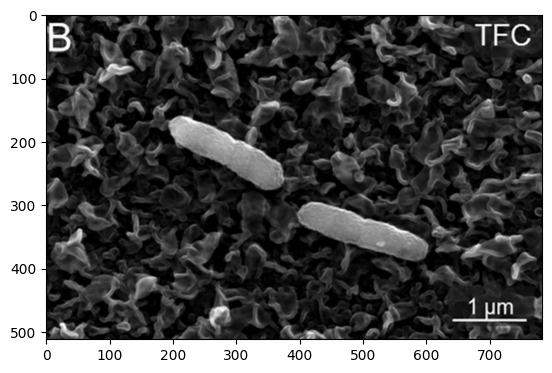

In [ ]:
image_0 = Image(f'/content/Kaggle/EMPS/images/{graph_name}')
print(image_0)
image_0.show()

## Check Mask

Mask info:
size           = 400896
shape          = (512, 783)
data type      = uint16
variable type  = <class 'numpy.ndarray'>

path           = /content/Kaggle/EMPS/segmaps/2387be5eaf.png
name           = 2387be5eaf.png
boundary       = {'x_min': 0, 'x_max': 512, 'y_min': 0, 'y_max': 783, 'x_len': 512, 'y_len': 783, 'diagonal': 935.5388821422656}
vertices       = [(0, 0), (512, 0), (512, 783), (0, 783)]
patch_list     = []
patch_num      = 0




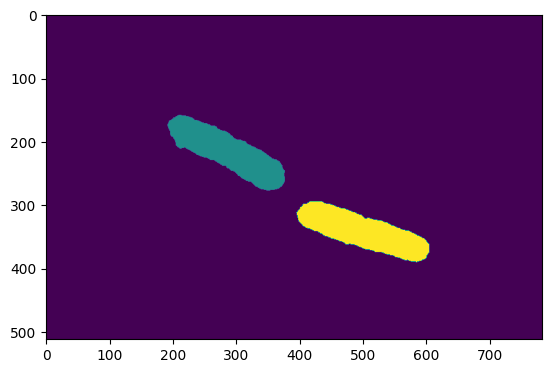

In [ ]:
mask_0 = Mask(f'/content/Kaggle/EMPS/segmaps/{graph_name}')
print(mask_0)
mask_0.show()

In [ ]:
print(mask_0.data[200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

## Check Patch

Patch info:
size           = 60000
shape          = (100, 200, 3)
data type      = float64
variable type  = <class 'numpy.ndarray'>

boundary       = {'x_min': 400, 'x_max': 500, 'y_min': 0, 'y_max': 200, 'x_len': 100, 'y_len': 200, 'diagonal': 223.60679774997897}
vertices       = [(400, 0), (500, 0), (500, 200), (400, 200)]




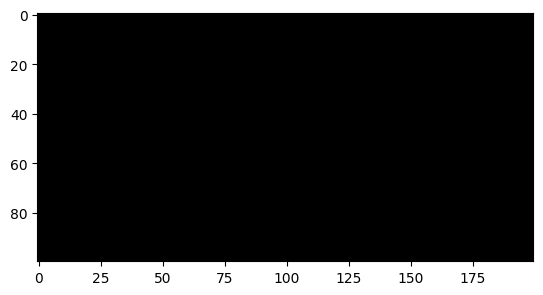

In [ ]:
patch_0 = Patch(xy_limits=[400,500,0,200],
                color_mode='black')
print(patch_0)
patch_0.show()

## Check Image with Patch

### Black Patch

patch id = 0
{'x_min': 400, 'x_max': 500, 'y_min': 0, 'y_max': 200, 'x_len': 100, 'y_len': 200, 'diagonal': 223.60679774997897}
[(400, 0), (500, 0), (500, 200), (400, 200)]
black


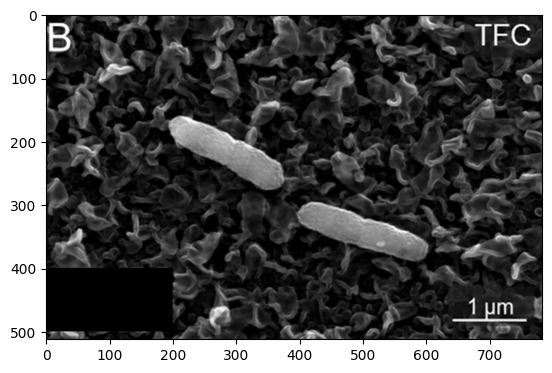

In [ ]:
# reset patches
image_0.patch_list = []

# attach patch
image_0.attach_patch(patch_0)

# print attached patches
for index, patch_i in enumerate(image_0.patch_list):
  print(f'patch id = {index}')
  print(patch_i.boundaries)
  print(patch_i.vertices)
  print(patch_i.color_mode)

# plot
image_0.show(show_pathces=True)

### Transpatent Patch

patch id = 0
Transparent


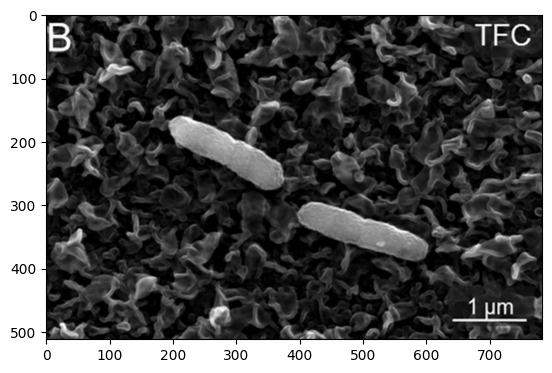

In [ ]:
# re-color attached patch
for index, patch_i in enumerate(image_0.patch_list):
  print(f'patch id = {index}')
  patch_i.color_mode = 'Transparent'
  print(patch_i.color_mode)
  patch_i.get_colored()

# plot
image_0.show(show_pathces=True)

### BinaryInterpolation Patch (4Bonds)


patch id = 0
255


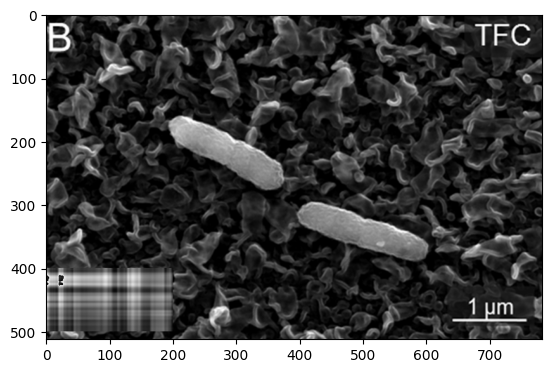

In [ ]:
# re-color attached patch
for index, patch_i in enumerate(image_0.patch_list):

  print(f'patch id = {index}')

  patch_i.color_mode = 'BinaryInterpolation_4Bonds'
  patch_i.get_colored()

  print(np.max(patch_i.data))
  #patch_i.show()


# plot
image_0.show(show_pathces=True)

### BinaryInterpolation Patch (4Points)

patch id = 0


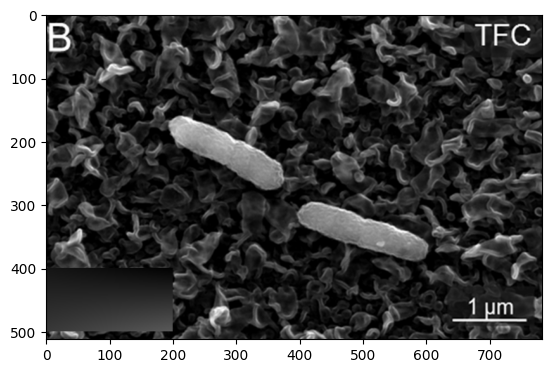

In [ ]:
# re-color attached patch
for index, patch_i in enumerate(image_0.patch_list):

  print(f'patch id = {index}')

  patch_i.color_mode = 'BinaryInterpolation_4Points'
  patch_i.get_colored()

  #print(patch_i.data)
  #patch_i.show()
  #print(np.max(patch_i.data))

# plot
image_0.show(show_pathces=True)

### BinaryInterpolation (Sliding)

patch id = 0


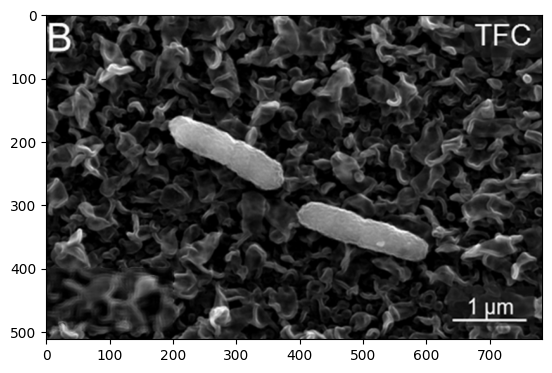

In [ ]:
# re-color attached patch
for index, patch_i in enumerate(image_0.patch_list):

  print(f'patch id = {index}')

  patch_i.color_mode = 'BinaryInterpolation_Sliding'
  patch_i.get_colored()

  #print(patch_i.data)
  #patch_i.show()
  #print(np.max(patch_i.data))

# plot
image_0.show(show_pathces=True)

## Check Patch for Mask

Patch info:
size           = 27000
shape          = (90, 100)
data type      = int64
variable type  = <class 'numpy.ndarray'>

boundary       = {'x_min': 10, 'x_max': 100, 'y_min': 0, 'y_max': 100, 'x_len': 90, 'y_len': 100, 'diagonal': 134.5362404707371}
vertices       = [(10, 0), (100, 0), (100, 100), (10, 100)]




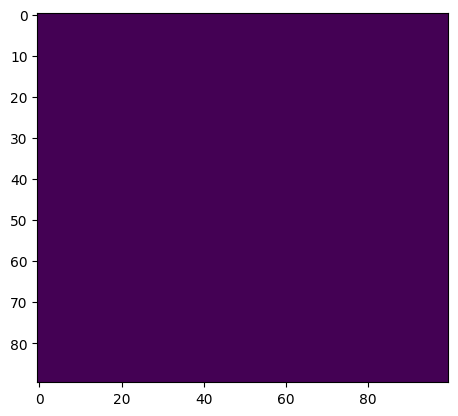

In [ ]:
patch_0 = Patch(xy_limits=[10,100,0,100],
         color_mode='GrayScale_background')
patch_0.get_colored()
print(patch_0)
patch_0.show()

## CHeck Mask with Patch

patch id = 0
{'x_min': 10, 'x_max': 100, 'y_min': 0, 'y_max': 100, 'x_len': 90, 'y_len': 100, 'diagonal': 134.5362404707371}
[(10, 0), (100, 0), (100, 100), (10, 100)]


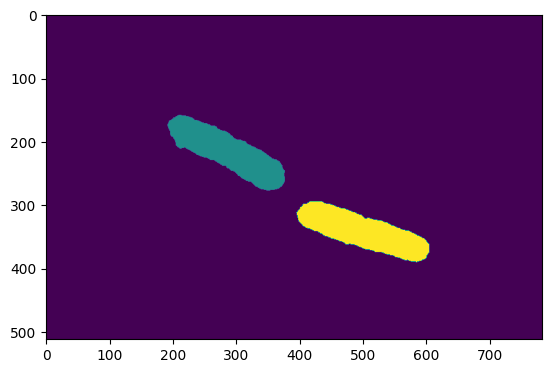

In [ ]:
# reset patches
mask_0.patch_list = []

# attach patch
mask_0.attach_patch(patch_0)

# print attached patches
for index, patch_i in enumerate(mask_0.patch_list):
  print(f'patch id = {index}')
  print(patch_i.boundaries)
  print(patch_i.vertices)

# plot
mask_0.show(show_pathces=True)

# Single Excution

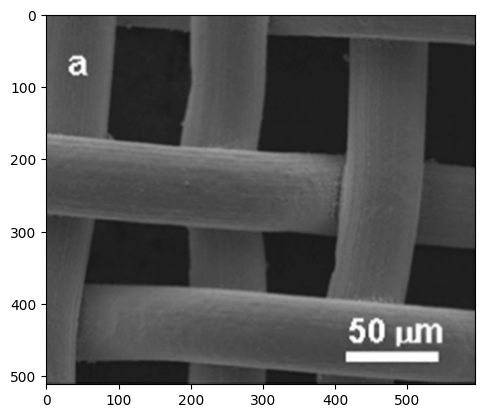

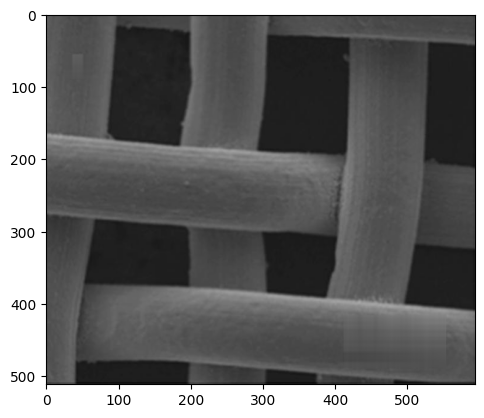

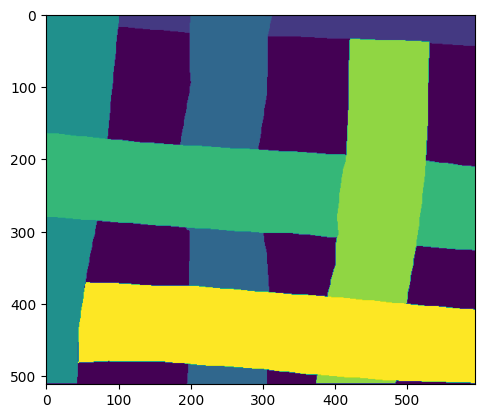

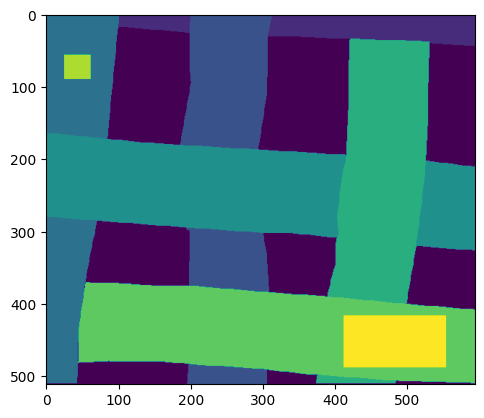

In [ ]:
# determine work directory
image_output_path = '/content/OUTPUT/EMPS/images'
image_input_path  = '/content/Kaggle/EMPS/images'
mask_output_path  = '/content/OUTPUT/EMPS/segmaps'
mask_input_path   = '/content/Kaggle/EMPS/segmaps'

# create work directory
os.makedirs(image_output_path, exist_ok=True)
os.makedirs(mask_output_path,  exist_ok=True)

# determine target
graph_name = '41c25dca24'

# fetch  image
imgae_exe  = Image(f'{image_input_path}/{graph_name}.png')

# fetch  mask
mask_exe   = Mask(f'{mask_input_path}/{graph_name}.png')

# reset patches
imgae_exe.patch_list = []

# fetch patch info
patch_databas = Patch_Databas()
xy_limits_list, color_modes_list = patch_databas.fetch_patch(graph_name)

# create patches
patch_list = []
for patch_i_xy_limit, patch_color_mode in zip(xy_limits_list, color_modes_list):
  patch_i = Patch(xy_limits=patch_i_xy_limit,color_mode=patch_color_mode)
  patch_list.append(patch_i)

# attach patch to Image
for patch_i in patch_list:
  imgae_exe.attach_patch(patch_i)

# plot image
imgae_exe.show()
imgae_exe.show(show_pathces=True)

# save image
io.imsave(f'{image_output_path}/{graph_name}.png', imgae_exe.data_with_patch)

# attach patch to Mask
for patch_i in patch_list:
  patch_i.color_mode='GrayScale_out' # use 'GrayScale_background' for 'hide' patches as background
  mask_exe.attach_patch(patch_i)

# plot mask
mask_exe.show()
mask_exe.show(show_pathces=True)

# save mask
io.imsave(f'{mask_output_path}/{graph_name}.png', imgae_exe.data_with_patch)

# Multi-Excution


In [ ]:
# determine work directory
image_output_path = '/content/OUTPUT/EMPS/images'
image_input_path  = '/content/Kaggle/EMPS/images'
mask_output_path  = '/content/OUTPUT/EMPS/segmaps'
mask_input_path   = '/content/Kaggle/EMPS/segmaps'

# create work directory
os.makedirs(image_output_path, exist_ok=True)
os.makedirs(mask_output_path,  exist_ok=True)


# initialization
patch_databas = Patch_Databas()
graph_patches_dic = patch_databas.patches_dic
graph_num = len(patch_databas.patches_dic)
index = 1
warnings.filterwarnings("ignore", category=UserWarning) # skip low contrast warning

for graph_name in tqdm(graph_patches_dic):
  try:
    # fetch  image
    imgae_exe  = Image(f'{image_input_path}/{graph_name}.png')

    # fetch  mask
    mask_exe   = Mask(f'{mask_input_path}/{graph_name}.png')

    # reset patches
    imgae_exe.patch_list = []

    # fetch patch info
    xy_limits_list, color_modes_list = patch_databas.fetch_patch(graph_name)

    # create patches
    patch_list = []
    for patch_i_xy_limit, patch_color_mode in zip(xy_limits_list, color_modes_list):
      patch_i = Patch(xy_limits=patch_i_xy_limit,color_mode=patch_color_mode)
      patch_list.append(patch_i)

    # attach patch to Image
    for patch_i in patch_list:
      imgae_exe.attach_patch(patch_i)

    # save image
    io.imsave(f'{image_output_path}/{graph_name}.png', imgae_exe.data_with_patch)

    # attach patch to Mask
    for patch_i in patch_list:
      patch_i.color_mode='GrayScale_background'
      mask_exe.attach_patch(patch_i)

    # save mask
    io.imsave(f'{mask_output_path}/{graph_name}.png', imgae_exe.data_with_patch)

    index += 1

  except Exception as e:
    print(f'Error: graph name = {graph_name}, index = {index}/{graph_num}')
    print(e)

# zip the output folder
try:
  os.remove('/content/OUTPUT.zip')
except:
  pass
zip_folder('/content/OUTPUT', '/content/OUTPUT.zip')

100%|██████████| 465/465 [05:30<00:00,  1.41it/s]
